In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tfd = tfp.distributions
from tqdm import tqdm_notebook as tqdm, trange
tfd = tfp.distributions

First we want to give the Fisher information, and find a cheap way to invert it (Sherman Morrison)

In [729]:
def _calculate_rankone(alphas):
    alpha0 = tf.reduce_sum(alphas, axis = -1)
    dg_a0 = tf.math.polygamma(1., alpha0)
    res = tf.transpose(dg_a0 * tf.ones((alphas.shape[1], alphas.shape[1], alphas.shape[0], )), (2, 0, 1)) # a more readable way of writing this is probably einsum
    return res

def dirichlet_fisher(alphas):
    dg_a = tf.math.polygamma(1., alphas)
    D = tf.linalg.diag(dg_a)
    R1 = _calculate_rankone(alphas)
    
    return D-R1

@tf.function
def dirichlet_fisher_inv(alphas):
    alpha0 = tf.reduce_sum(alphas, axis=-1)
    dg_a0 = tf.math.polygamma(1., alpha0)
    dg_a = tf.math.polygamma(1., alphas)
    inv_dg_a = 1/dg_a
    
    A_inv = tf.linalg.diag(inv_dg_a) # part 1
    
    A_inv_mul_one = inv_dg_a # part 2
    corr_top = tf.einsum('ki,kj->kij', A_inv_mul_one, A_inv_mul_one)
    corr_bot = 1/(-dg_a0) + tf.reduce_sum(inv_dg_a, axis = -1)

    return (A_inv - corr_top/tf.reshape(corr_bot, (-1, 1, 1)))

@tf.function
def multiply_by_fisher_inv(alphas, x):
    # alphas is of shape (N, D)
    # x of shape (N, D)
    alpha0 = tf.reduce_sum(alphas, axis=-1, keepdims = True)
    dg_a0 = tf.math.polygamma(1., alpha0)
    dg_a = tf.math.polygamma(1., alphas)
    inv_dg_a = 1/dg_a
    
    # first get the multiply by inv diag matrix
    A_inv_mul_x = inv_dg_a * x
    Corr_top_mul_x = inv_dg_a * tf.reduce_sum(A_inv_mul_x, axis=-1, keepdims=True) # (N, D) * (N, 1)
    Corr_bot = 1/(-dg_a0) + tf.reduce_sum(inv_dg_a, axis = -1, keepdims = True)
    Corr_mul_x = Corr_top_mul_x/Corr_bot
    
    return A_inv_mul_x - Corr_mul_x

In [738]:
ts=(50,100)
tas = np.exp(np.random.uniform(size=ts)).astype('float32')
tas_tfv = tf.Variable(tas)
tx = np.random.normal(size=ts).astype('float32')

In [739]:
%timeit tf.einsum('ijk,ik->ij', dirichlet_fisher_inv(tas), tx)

The slowest run took 14.02 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.14 ms per loop


In [740]:
%timeit multiply_by_fisher_inv(tas, tx)

The slowest run took 22.08 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.21 ms per loop


In [565]:
with tf.GradientTape() as tape_:
    with tf.GradientTape() as tape:
        loss = -tf.reduce_sum(tfd.Dirichlet(tas_tfv).log_prob(np.ones((5, 10))))
    dJda = tape.jacobian(loss, [tas_tfv,])[0]
s = tape_.jacobian(dJda, [tas_tfv,])


W0603 22:11:53.096261 4376067584 def_function.py:120] 11 out of the last 11 calls to <function pfor.<locals>.f at 0x7fd3ede1eea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
W0603 22:11:53.431252 4376067584 def_function.py:120] 11 out of the last 11 calls to <function pfor.<locals>.f at 0x7fd3ede1eea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) cre

tf autodiff results

In [566]:
tf.reshape(s, (50, 50))[:10, :10]

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[ 0.4253827 , -0.05337556, -0.05337556, -0.05337556, -0.05337556,
        -0.05337556, -0.05337556, -0.05337556, -0.05337556, -0.05337556],
       [-0.05337556,  0.59990466, -0.05337556, -0.05337556, -0.05337556,
        -0.05337556, -0.05337556, -0.05337556, -0.05337556, -0.05337556],
       [-0.05337556, -0.05337556,  0.4728442 , -0.05337556, -0.05337556,
        -0.05337556, -0.05337556, -0.05337556, -0.05337556, -0.05337556],
       [-0.05337556, -0.05337556, -0.05337556,  1.052947  , -0.05337556,
        -0.05337556, -0.05337556, -0.05337556, -0.05337556, -0.05337556],
       [-0.05337556, -0.05337556, -0.05337556, -0.05337556,  0.554247  ,
        -0.05337556, -0.05337556, -0.05337556, -0.05337556, -0.05337556],
       [-0.05337556, -0.05337556, -0.05337556, -0.05337556, -0.05337556,
         0.58102   , -0.05337556, -0.05337556, -0.05337556, -0.05337556],
       [-0.05337556, -0.05337556, -0.05337556, -0.05337556, -0.05337

In [569]:
tf.reshape(s, (50, 50)).numpy()[10:20, 10:20]

array([[ 1.5485755 , -0.05973797, -0.05973797, -0.05973797, -0.05973797,
        -0.05973797, -0.05973797, -0.05973797, -0.05973797, -0.05973797],
       [-0.05973797,  0.6674333 , -0.05973797, -0.05973797, -0.05973797,
        -0.05973797, -0.05973797, -0.05973797, -0.05973797, -0.05973797],
       [-0.05973797, -0.05973797,  1.3215861 , -0.05973797, -0.05973797,
        -0.05973797, -0.05973797, -0.05973797, -0.05973797, -0.05973797],
       [-0.05973797, -0.05973797, -0.05973797,  0.45904303, -0.05973797,
        -0.05973797, -0.05973797, -0.05973797, -0.05973797, -0.05973797],
       [-0.05973797, -0.05973797, -0.05973797, -0.05973797,  0.4951418 ,
        -0.05973797, -0.05973797, -0.05973797, -0.05973797, -0.05973797],
       [-0.05973797, -0.05973797, -0.05973797, -0.05973797, -0.05973797,
         0.46172208, -0.05973797, -0.05973797, -0.05973797, -0.05973797],
       [-0.05973797, -0.05973797, -0.05973797, -0.05973797, -0.05973797,
        -0.05973797,  0.8622595 , -0.05973797

My implementation

In [567]:
dirichlet_fisher(tas)[0]

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[ 0.4253827 , -0.05337556, -0.05337556, -0.05337556, -0.05337556,
        -0.05337556, -0.05337556, -0.05337556, -0.05337556, -0.05337556],
       [-0.05337556,  0.59990466, -0.05337556, -0.05337556, -0.05337556,
        -0.05337556, -0.05337556, -0.05337556, -0.05337556, -0.05337556],
       [-0.05337556, -0.05337556,  0.4728442 , -0.05337556, -0.05337556,
        -0.05337556, -0.05337556, -0.05337556, -0.05337556, -0.05337556],
       [-0.05337556, -0.05337556, -0.05337556,  1.052947  , -0.05337556,
        -0.05337556, -0.05337556, -0.05337556, -0.05337556, -0.05337556],
       [-0.05337556, -0.05337556, -0.05337556, -0.05337556,  0.554247  ,
        -0.05337556, -0.05337556, -0.05337556, -0.05337556, -0.05337556],
       [-0.05337556, -0.05337556, -0.05337556, -0.05337556, -0.05337556,
         0.58102   , -0.05337556, -0.05337556, -0.05337556, -0.05337556],
       [-0.05337556, -0.05337556, -0.05337556, -0.05337556, -0.05337

In [568]:
dirichlet_fisher(tas)[1]

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[ 1.5485755 , -0.05973797, -0.05973797, -0.05973797, -0.05973797,
        -0.05973797, -0.05973797, -0.05973797, -0.05973797, -0.05973797],
       [-0.05973797,  0.6674333 , -0.05973797, -0.05973797, -0.05973797,
        -0.05973797, -0.05973797, -0.05973797, -0.05973797, -0.05973797],
       [-0.05973797, -0.05973797,  1.3215861 , -0.05973797, -0.05973797,
        -0.05973797, -0.05973797, -0.05973797, -0.05973797, -0.05973797],
       [-0.05973797, -0.05973797, -0.05973797,  0.45904303, -0.05973797,
        -0.05973797, -0.05973797, -0.05973797, -0.05973797, -0.05973797],
       [-0.05973797, -0.05973797, -0.05973797, -0.05973797,  0.4951418 ,
        -0.05973797, -0.05973797, -0.05973797, -0.05973797, -0.05973797],
       [-0.05973797, -0.05973797, -0.05973797, -0.05973797, -0.05973797,
         0.46172208, -0.05973797, -0.05973797, -0.05973797, -0.05973797],
       [-0.05973797, -0.05973797, -0.05973797, -0.05973797, -0.05973

The Sherman Morrison formula will be faster than naive inversion, and more stable

In [665]:
tf.reduce_max(tf.linalg.inv(dirichlet_fisher(tas)) - dirichlet_fisher_inv(tas))

<tf.Tensor: shape=(), dtype=float32, numpy=9.536743e-07>

In [571]:
%timeit tf.linalg.inv(dirichlet_fisher(tas))

The slowest run took 4.63 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 242 µs per loop


In [572]:
%timeit dirichlet_fisher_inv(tas)

1000 loops, best of 3: 196 µs per loop


### Now let's fit a model with Dirichlet distribution

Let's first fit a simple scenario: 

for $ x_n \sim Dir(\alpha)$, we want to find

$$ \arg\max_{\alpha} \sum_{n}\log p(x_n | \alpha) $$

We simply build nonnegative parameters $a$, forward propagate with identity(a), backward propagate with $\partial a I(a)^{-1}$

In [715]:
# we fit T Dirichlet of length K
N = 1000
K = 50
T = 30
baseline_a = 0.5
true_alpha = np.ones((T, K)).astype('float32').reshape((T, K)) * baseline_a
X = tfd.Dirichlet(true_alpha).sample(N)

In [719]:
# first do the normal gradient version
params_gd = tf.Variable(tf.initializers.GlorotNormal()((T, K)))
opt_gd = tf.keras.optimizers.Adam(1e-1)

In [720]:
def gradient_based_solution(params, opt, epochs, verbose = True):
    loss_rec = []
    tqdm_range = tqdm(range(epochs))

    for e in tqdm_range:
        with tf.GradientTape() as tape:
            alpha_hat = tf.math.exp(params)
            dirichlet = tfd.Dirichlet(alpha_hat)
            loss = -tf.reduce_mean(dirichlet.log_prob(X))

        grads = tape.gradient(loss, [params,])
        opt.apply_gradients(zip(grads, [params,]))
        loss_rec.append(tf.reduce_sum(loss))
        tqdm_range.set_description("loss: {:.2f}".format(tf.reduce_sum(loss).numpy()), refresh = True)
    
    if verbose:
        plt.plot(loss_rec)
        plt.show()
    
    return loss_rec

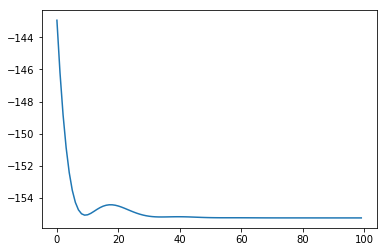

In [721]:
loss_gd = gradient_based_solution(params_gd, opt_gd, 100)

In [722]:
tf.math.exp(params_gd)

<tf.Tensor: shape=(30, 50), dtype=float32, numpy=
array([[0.50182974, 0.5123689 , 0.5300978 , ..., 0.49764228, 0.5112477 ,
        0.5101792 ],
       [0.49546367, 0.50833195, 0.51665086, ..., 0.49280983, 0.52041316,
        0.5037779 ],
       [0.4915591 , 0.5043517 , 0.5088133 , ..., 0.4910881 , 0.48700076,
        0.48871067],
       ...,
       [0.4875482 , 0.4972916 , 0.5049345 , ..., 0.5110466 , 0.5093135 ,
        0.48865536],
       [0.52456087, 0.50923556, 0.5006904 , ..., 0.5044697 , 0.5142641 ,
        0.49270153],
       [0.5146054 , 0.483903  , 0.510103  , ..., 0.5025521 , 0.4991735 ,
        0.4975885 ]], dtype=float32)>

In [723]:
# natural gradient version
@tf.custom_gradient
def natural_gradient_on_backprop(a, ):
    def grad(da):
        Ia = dirichlet_fisher_inv(a)
        da_tilde = tf.einsum("tmn,tn->tm", Ia, da)
        return da_tilde
    return tf.identity(a), grad

# gradient works?
@tf.custom_gradient
def gradient_on_backprop(a, ):
    def grad(da):
        return da
    return tf.identity(a), grad

In [724]:
params_ngd = tf.Variable(tf.initializers.GlorotNormal()((T, K)))
# params_ngd = tf.Variable(tf.initializers.Zeros()((T, K)))
opt_ngd = tf.keras.optimizers.SGD(10.0)

In [725]:
def natural_gradient_based_solution(params, opt, epochs, verbose = True):
    loss_rec = []
    tqdm_range = tqdm(range(epochs))

    for e in tqdm_range:
        with tf.GradientTape() as tape:
    #         alpha_hat = gradient_on_backprop(tf.math.exp(params_ngd))
            alpha_hat = natural_gradient_on_backprop(tf.math.exp(params))
            dirichlet = tfd.Dirichlet(alpha_hat)
            loss = -tf.reduce_mean(dirichlet.log_prob(X))

        grads = tape.gradient(loss, [params,])
        opt.apply_gradients(zip(grads, [params,]))
        loss_rec.append(loss.numpy())
        tqdm_range.set_description("loss: {:.2f}".format(loss.numpy()), refresh = True)

    if verbose:
        plt.plot(loss_rec)
        plt.show()
    
    return loss_rec

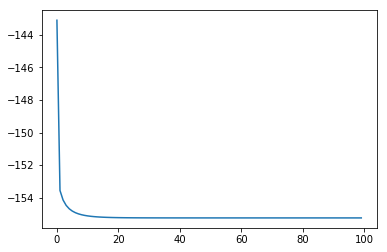

In [726]:
loss_ngd = natural_gradient_based_solution(params_ngd, opt_ngd, 100)

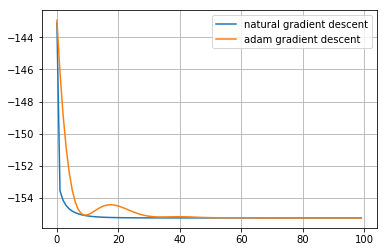

In [727]:
plt.plot(loss_ngd, label='natural gradient descent')
plt.plot(loss_gd, label='adam gradient descent')
plt.legend()
plt.grid()
plt.show()

In [728]:
tf.math.exp(params_ngd)

<tf.Tensor: shape=(30, 50), dtype=float32, numpy=
array([[0.50260955, 0.5124561 , 0.5291188 , ..., 0.50191057, 0.5116314 ,
        0.51029104],
       [0.49563968, 0.50896084, 0.5170311 , ..., 0.49354663, 0.52075803,
        0.5041253 ],
       [0.4930572 , 0.5053195 , 0.5106938 , ..., 0.49280816, 0.4875715 ,
        0.4893908 ],
       ...,
       [0.48790887, 0.49566606, 0.5050567 , ..., 0.51088935, 0.5092869 ,
        0.48891598],
       [0.5244851 , 0.50973135, 0.5010865 , ..., 0.50427765, 0.51521814,
        0.49237084],
       [0.5144611 , 0.4876577 , 0.5126553 , ..., 0.5027778 , 0.49962112,
        0.49782112]], dtype=float32)>